In [1]:
import requests
import json
import numpy as np
import torch
import cv2
import io
from PIL import Image
from captum.attr import visualization
import matplotlib.pyplot as plt

In [2]:
endpoint = 'http://localhost:5000/attentions'

img_url = 'https://pictures-of-cats.org/wp-content/uploads/2018/02/mouse-and-cat-x.jpg'
text = 'A mouse'

In [3]:
def get_attentions_from_api(endpoint, img_url, text):
    headers = {'Content-Type': 'application/json'}

    data = {
        'img_url': img_url,
        'text': text
    }
    
    response = requests.post(endpoint, headers=headers, json=data)
    
    response_headers = response.headers
    response_body = response.json()
    
    return response_body

response_dict = get_attentions_from_api(endpoint, img_url, text)

In [5]:
# parse response dict

print(response_dict.keys())

cos_sim = response_dict['cos_sim']
image_attention = response_dict['image_attention']
image_relevance = torch.Tensor(response_dict['image_relevance'])
img_coords = response_dict['img_coords']
img_emb = torch.Tensor(response_dict['img_emb'])
text_attention = response_dict['text_attention']
text_relevance = torch.Tensor(response_dict['text_relevance'])
txt_emb = torch.Tensor(response_dict['txt_emb'])
img_tokens = response_dict['img_tokens']
text_tokens = torch.Tensor(response_dict['text_tokens'])
img_preprocess = torch.Tensor(response_dict['img_preprocess'])
text_tokens_decoded = response_dict['text_tokens_decoded']

dict_keys(['cos_sim', 'image_attention', 'image_relevance', 'img_coords', 'img_emb', 'img_preprocess', 'img_tokens', 'text_attention', 'text_relevance', 'text_tokens', 'text_tokens_decoded', 'txt_emb'])


In [6]:
def show_heatmap_on_text(text, text_encoding, R_text, text_tokens, text_tokens_decoded):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

In [7]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,There is a cat in this picture


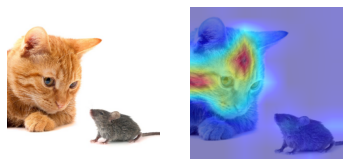

In [13]:
def plot_clip_saliency(endpoint, img_url, text):

    response_dict = get_attentions_from_api(endpoint, img_url, text)

    r = requests.get(img_url)
    img = Image.open(io.BytesIO(r.content))
    # text = clip.tokenize(texts).to(device)
    texts = [text]

    R_image = torch.Tensor(response_dict['image_relevance'])
    R_text = torch.Tensor(response_dict['text_relevance'])
    text_tokens = torch.Tensor(response_dict['text_tokens'])
    text_tokens_decoded = response_dict['text_tokens_decoded']
    img_preprocess = torch.Tensor(response_dict['img_preprocess'])
    
    batch_size = text_tokens.shape[0]
    for i in range(batch_size):
        show_heatmap_on_text(texts[i], text_tokens[i], R_text[i], text_tokens, text_tokens_decoded)
        show_image_relevance(R_image[i], img_preprocess, orig_image=img)
        plt.show()

img_url = 'https://pictures-of-cats.org/wp-content/uploads/2018/02/mouse-and-cat-x.jpg'
text = 'There is a cat in this picture'

# img_url = 'https://www.linguahouse.com/linguafiles/md5/d33da85b80c5fadd52b0753f6092fbc0'
# text = 'A house'
        
plot_clip_saliency(endpoint, img_url, text)